In [1]:
import torch
import numpy as np
import os
import json
import joblib
from torch.utils.data import Dataset,DataLoader
from itertools import repeat
import pandas as pd
import math
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pathlib import Path
data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
image_dir = Path('/common/users/vk405/EnergyLab/Data')
proc_data_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData')
df = pd.read_csv(f'{data_dir}/tgtimgs.csv')



In [3]:
df.tail()

,Date,MST,Imgs,Target
100882,2017-11-30,15:20,['/common/users/vk405/EnergyLab/Data/20171130/...,161.97970
100883,2017-11-30,15:30,['/common/users/vk405/EnergyLab/Data/20171130/...,133.98670
100884,2017-11-30,16:00,['/common/users/vk405/EnergyLab/Data/20171130/...,47.26993
100885,2017-11-30,16:10,['/common/users/vk405/EnergyLab/Data/20171130/...,15.55378
100886,2017-11-30,16:20,['/common/users/vk405/EnergyLab/Data/20171130/...,9.61039


In [4]:
class Dset(Dataset):
    def __init__(self,split= 'train',data_dir='/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/',
    image_dir='/common/users/vk405/EnergyLab/Data/ProcData'):
        self.split = split

        #hardcoded dir locs 
        self.data_dir = Path(data_dir)
        self.image_dir = Path(image_dir) 
        
        base_df = pd.read_csv(f'{self.data_dir}/tgtimgs.csv')
        base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0
        
        trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
        self.scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))
        #splits are hardcoded as per the original paper
        if self.split == 'train':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
            
        elif self.split == 'valid':
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])
            
        else:
            self.df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year > 2015])
        #set an upper-threshold.
        self.df.loc[self.df.index[self.df['Target']>=1250.0],'Target'] = 1250.0
        #self.df[self.df['Target']>=1300.0]['Target'] = 1300.0
        rescaled = self.scalar.transform(self.df['Target'].values.reshape(-1,1))
        self.df['Target'] = np.squeeze(rescaled)
        
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,ind):
        try:
            imgs = sorted(eval(self.df.iloc[ind]['Imgs']),key = lambda x: int(x.split('/')[-1].split('.')[0]))
            target = self.df.iloc[ind]['Target']
            #image_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData') 
            proc_imgs = [self.image_dir/(x.split('/')[-1].split('.')[0]+'.joblib') for x in imgs]
            proc_arrays = [joblib.load(ele) for ele in proc_imgs]
        except:
            print(ind)
            
        return (np.concatenate(proc_arrays,-1).reshape(-1,256,256))/255.0,target




    

In [4]:
dset = Dset()
dset.df.iloc[3220]

Date                                             2012-02-29
MST                                                   08:40
Imgs      ['/common/users/vk405/EnergyLab/Data/20120229/...
Target                                             0.284907
Name: 3220, dtype: object

In [9]:
#sanity check

# for i in tqdm(range(len(dset))):
#     try:
#         o=dset[i]
#     except:
#         print(i)

100%|██████████| 58531/58531 [03:37<00:00, 269.48it/s]


In [ ]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])

<AxesSubplot:ylabel='Frequency'>

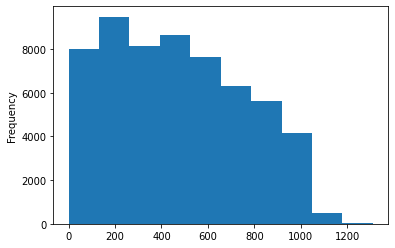

In [7]:
trn_df['Target'].plot.hist()

In [29]:
trn_df.loc[trn_df.index[trn_df['Target']>=1250.0],'Target'] = 1250.0

<AxesSubplot:ylabel='Frequency'>

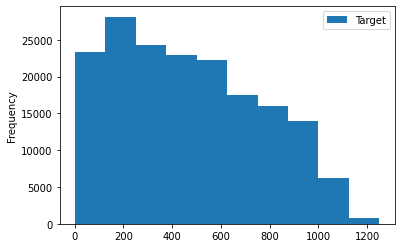

In [30]:
trn_df.plot.hist()

<AxesSubplot:ylabel='Frequency'>

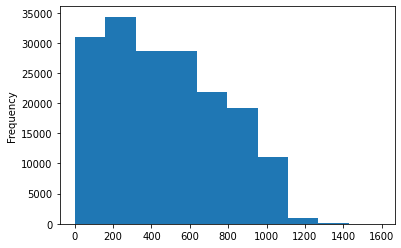

In [22]:
trn_df['Target'].plot.hist()

In [22]:
df_trn = Dset('train')

In [38]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0
out = base_df['Imgs'].apply(lambda x: eval(x)).apply(lambda x: not isinstance(x,list))
sum(out)

0

In [45]:
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
base_df.loc[base_df.index[base_df['Target']>=1250.0],'Target'] = 1250.0

trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))

df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])

df.loc[df.index[df['Target']>=1250.0],'Target'] = 1250.0
#self.df[self.df['Target']>=1300.0]['Target'] = 1300.0
rescaled = scalar.transform(df['Target'].values.reshape(-1,1))
out = df['Imgs'].apply(lambda x: eval(x)).apply(lambda x: not isinstance(x,list))
sum(out)
      

0

In [50]:
np.squeeze(rescaled)

array([0.02127024, 0.03398448, 0.05475296, ..., 0.03809065, 0.01229214,
       0.00736006])

In [51]:
df['Target'] = rescaled

In [53]:
out = df['Imgs'].apply(lambda x: eval(x)).apply(lambda x: not isinstance(x,list))
sum(out)


0

In [39]:
df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
out = df['Imgs'].apply(lambda x: eval(x)).apply(lambda x: not isinstance(x,list))
sum(out)

0

In [56]:
df_trn = Dset('train')

sum(df_trn.df['Imgs'].apply(lambda x: eval(x)).apply(lambda x: not isinstance(x,list)))

0

In [24]:
df_trn.df.iloc[10565]['Imgs']

"['/common/users/vk405/EnergyLab/Data/20120802/20120802115000.raw.jpg', '/common/users/vk405/EnergyLab/Data/20120802/20120802114000.raw.jpg']"

In [14]:
df_trn.df.iloc[10564]['Imgs']

"['/common/users/vk405/EnergyLab/Data/20120802/20120802114000.raw.jpg', '/common/users/vk405/EnergyLab/Data/20120802/20120802113000.raw.jpg']"

In [13]:
df_trn.df

,Date,MST,Imgs,Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,0.012111
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,0.019796
2,2012-01-01,08:00,['/common/users/vk405/EnergyLab/Data/20120101/...,0.034064
3,2012-01-01,08:10,['/common/users/vk405/EnergyLab/Data/20120101/...,0.048355
4,2012-01-01,08:20,['/common/users/vk405/EnergyLab/Data/20120101/...,0.062177
...,...,...,...,...
175582,2014-12-31,15:50,['/common/users/vk405/EnergyLab/Data/20141231/...,0.080331
175583,2014-12-31,16:00,['/common/users/vk405/EnergyLab/Data/20141231/...,0.062049
175584,2014-12-31,16:10,['/common/users/vk405/EnergyLab/Data/20141231/...,0.044130
175585,2014-12-31,16:20,['/common/users/vk405/EnergyLab/Data/20141231/...,0.011740


In [41]:
x,y = df_trn[0]

In [42]:
x[:,:,0].max()

1.0

In [1]:
#architecture



In [8]:
def SCNN(n_ch=6):
    
    model = []
    model.append(nn.Conv2d(in_channels=n_ch, out_channels=64, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))
    
    model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    #model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    #model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    #model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    #model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))

    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding="same"))
    model.append(nn.ReLU())
    model.append(nn.MaxPool2d((2,2),stride=(2,2)))




    return nn.Sequential(*model)


In [11]:
model = SCNN()

In [50]:
x.shape

(6, 256, 256)

In [51]:
x_out = model(torch.Tensor(x.reshape(1,6,256, 256)))

In [54]:
x_out.shape

torch.Size([1, 512, 4, 4])

In [52]:
nn.Flatten()(x_out).shape

torch.Size([1, 8192])

In [9]:
base_model = [SCNN()]

In [10]:
base_model.extend([nn.Flatten(),nn.Dropout(0.2),nn.Linear(8192,256),nn.Dropout(0.2),nn.Linear(256,1)])

In [11]:
class VggModel(pl.LightningModule):
    def __init__(self,hparams,dset=None):
        super().__init__()
        self.save_hyperparameters()

        
        if hparams.framecnt != 2:
            raise NotImplementedError

        #get the complete model
        base_model = [SCNN(hparams.framecnt*3)]
        base_model.extend([nn.Flatten(),nn.Dropout(hparams.dropoutp),nn.Linear(8192,256),nn.Dropout(hparams.dropoutp),nn.Linear(256,1)])
        self.net = nn.Sequential(*base_model)

    def forward(self,x):
        #keep this for inference
        out = self.net(x)
        return out

    
    def training_step(self,batch,batch_idx):
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.net(x.float()))

        loss = F.l1_loss(y_hat,y.float())
        self.log("train_loss",loss,on_step=True)
        return loss

    
    def validation_step(self,batch,batch_idx):
        #for training
        x,y = batch
        y_hat = torch.squeeze(self.net(x.float()))

        loss = F.l1_loss(y_hat,y.float())
        self.log("val_loss",loss,on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        lr = self.hparams.lr if 'lr' in self.hparams else 1e-5
        #lr=0.00001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False
        optimizer = torch.optim.Adam(self.parameters(), lr=lr,betas=(0.9,0.999),amsgrad=False)
        return optimizer




    

In [12]:
model = nn.Sequential(*base_model)

In [13]:
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
wandb_logger = lambda dir, version: WandbLogger(
    name="wandb", save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs


In [16]:
def run_model(cfg):
    pl.seed_everything(cfg.seed)
    dir = cfg.artifacts_loc
    version = str(cfg.version)
    logger_list = get_loggers(dir, version,cfg.loggers)
    cbs = []
    if "early_stop" in cfg.cbs:
        #? does'nt really work atm
        #params = cfg.model.cbs.early_stop
        earlystopcb = EarlyStopping(monitor='val_loss',mode="min",patience=3,verbose=False)
        cbs.append(earlystopcb)
    if "checkpoint" in cfg.cbs:
        store_path = dir + "ckpts/" + str(cfg.version) + "/"
        isExist = os.path.exists(store_path)
        if not isExist:
            os.makedirs(store_path)
        fname = "{epoch}-{val_loss:.2f}"
        params = cfg.checkpoint
        checkptcb = ModelCheckpoint(**params, dirpath=store_path, filename=fname)
        cbs.append(checkptcb)

    #wandb.init(project="solarforecast", config=cfg)
    if cfg.mode == 'train':
        trn_fdata = Dset(data_dir=cfg.data_dir,split=cfg.mode,image_dir= cfg.image_dir\
               )
        vld_fdata = Dset(data_dir=cfg.data_dir,split='valid',image_dir= cfg.image_dir)

        val_loader = DataLoader(vld_fdata,\
            batch_size=cfg.batch_size,shuffle=False,num_workers=4,pin_memory=True)
        train_loader = DataLoader(trn_fdata,\
            batch_size=cfg.batch_size,shuffle=True,num_workers=4,pin_memory=True)
            
        hparams = cfg    
        net = VggModel(hparams)
        trainer = pl.Trainer(
            logger=logger_list,callbacks=cbs, gpus=[2],deterministic=True, **cfg.trainer
        )
        trainer.fit(net,train_dataloaders=train_loader,val_dataloaders=val_loader)
        return trainer
        #trainer.tune(net,train_loader)
            
    else:
        pass
    

In [15]:
from argparse import Namespace
cfg = Namespace(
    version = 'trail',
    artifacts_loc = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/",
    data_dir = "/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/",
    image_dir = "/common/users/vk405/EnergyLab/Data/ProcData/",
    mode = 'train',
    loggers = ["csv"],
    seed = 0,
    cbs = ["checkpoint"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 30},
    checkpoint = {"save_top_k": 5,
    "monitor": "val_loss","mode":"min"},
    dropoutp=0.2,
    framecnt=2,
    lr = 1.5e-5,
    batch_size=64
)

In [12]:

run_model(cfg)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/csvlogs/trail exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 16.8 M
------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.256    Total estimated model params size (MB)
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /common/home/vk405/Projects/EnergyLab/Sola

Global seed set to 0


Epoch 5:  41%|████      | 469/1142 [04:04<05:50,  1.92it/s, loss=0.0679, v_num=rail] 

In [55]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [56]:
count_parameters(model)

+-----------+------------+
|  Modules  | Parameters |
+-----------+------------+
|  0.weight |    3456    |
|   0.bias  |     64     |
|  2.weight |   36864    |
|   2.bias  |     64     |
|  5.weight |   73728    |
|   5.bias  |    128     |
|  7.weight |   147456   |
|   7.bias  |    128     |
| 10.weight |   294912   |
|  10.bias  |    256     |
| 12.weight |   589824   |
|  12.bias  |    256     |
| 14.weight |   589824   |
|  14.bias  |    256     |
| 17.weight |  1179648   |
|  17.bias  |    512     |
| 19.weight |  2359296   |
|  19.bias  |    512     |
| 22.weight |  2359296   |
|  22.bias  |    512     |
| 24.weight |  2359296   |
|  24.bias  |    512     |
| 27.weight |  2359296   |
|  27.bias  |    512     |
| 29.weight |  2359296   |
|  29.bias  |    512     |
+-----------+------------+
Total Trainable Params: 14716416


14716416

#some sanity check if the baseline deepmodel has trained well. Let's compare with naive forcecast model.

In [3]:
metric_file = '/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/csvlogs/trail/metrics.csv'

data_file = pd.read_csv(metric_file)

,train_loss,epoch,step,val_loss
0,0.161652,0,49,NaN
1,0.198499,0,99,NaN
2,0.189742,0,149,NaN
3,0.125779,0,199,NaN
4,0.095414,0,249,NaN
...,...,...,...,...
574,0.044565,29,27299,NaN
575,0.058814,29,27349,NaN
576,0.052449,29,27399,NaN
577,0.044258,29,27449,NaN


<AxesSubplot:>

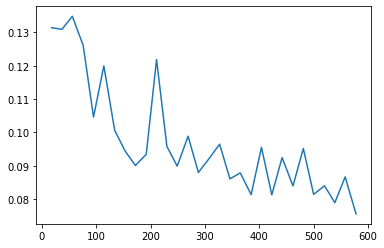

In [7]:
data_file['val_loss'].dropna().plot()


<AxesSubplot:>

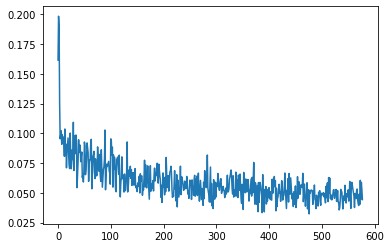

In [6]:
data_file['train_loss'].dropna().plot()

In [9]:
weight_loc = '/common/home/vk405/Projects/EnergyLab/Solar-forcast/artifacts/ckpts/trail/epoch=27-val_loss=0.08.ckpt'

In [13]:
data_dir = Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
base_df = pd.read_csv(f'{data_dir}/tgtimgs.csv')
vld_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year == 2015])

In [23]:
vld_df.head(2)

,Date,MST,Imgs,Target
175587,2015-01-01,10:00,['/common/users/vk405/EnergyLab/Data/20150101/...,305.080
175588,2015-01-01,10:10,['/common/users/vk405/EnergyLab/Data/20150101/...,100.016


In [50]:
trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))

In [54]:
scalar.inverse_transform([[0.16]])

array([[254.69779416]])

In [22]:
def transform(df):
    trn_df = pd.DataFrame(base_df.loc[pd.to_datetime(base_df['Date']).dt.year <= 2014])
    scalar = MinMaxScaler().fit(trn_df['Target'].values.reshape(-1,1))
    df.loc[df.index[df['Target']>=1250.0],'Target'] = 1250.0
#self.df[self.df['Target']>=1300.0]['Target'] = 1300.0
    rescaled = scalar.transform(df['Target'].values.reshape(-1,1))
    df['Target'] = rescaled[:,0]
    return df

        

In [17]:
!ls '/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/'

20120101.csv  20150101.csv		       tgtimgs.csv
20120601.csv  SRRL_measurement_timeseries.csv


In [18]:
#get original data

df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))

In [30]:
#get persistance model predictios

vld_df.iloc[0]['Date']

vld_df.iloc[0]['MST']

'10:00'

In [34]:
df_svd[(df_svd['Date']==vld_df.iloc[0]['Date']) & (df_svd['MST'] == vld_df.iloc[0]['MST'])]

,Date,MST,GHI
2393075,2015-01-01,10:00,305.08
3173356,2015-01-01,10:00,305.08
3953637,2015-01-01,10:00,305.08


In [41]:
one_day = df_svd[df_svd['Date']==vld_df.iloc[0]['Date']].reset_index(drop=True)

In [45]:
one_day['roll_GHI'] = one_day['GHI'].shift(-10)


In [49]:
one_day

,Date,MST,GHI,roll_GHI
0,2015-01-01,7:25,5.86459,28.5870
1,2015-01-01,7:26,6.56927,30.5948
2,2015-01-01,7:27,7.52287,32.4954
3,2015-01-01,7:28,10.23740,34.4483
4,2015-01-01,7:29,14.95910,36.4776
...,...,...,...,...
1675,2015-01-01,16:40,4.10389,NaN
1676,2015-01-01,16:41,3.67173,NaN
1677,2015-01-01,16:42,3.37306,NaN
1678,2015-01-01,16:43,3.00862,NaN
